The goal of this notebook is to investigate our 2nd current working hypothesis, which states that peak I(EEG;TIA) optimal lag converges at 500 ms or later. I will try to get this to work with subject 2 for now; if it works I will expand it to other subjects. 

In [9]:
import mne
from pathlib import Path
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from sklearn.preprocessing import StandardScaler
import random
import seaborn as sns

In [2]:
# Prepare the data for subject 2
data_path = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
file_path = data_path / "binepochs filtered ICArej P1AvgBOS2.set"
epochs = mne.io.read_epochs_eeglab(file_path)

auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]

auditory_epochs.filter(l_freq = 1., h_freq = 30., picks="eeg")
tactile_epochs.filter(l_freq = 1., h_freq = 30., picks="eeg")

X = epochs.get_data()  # shape (n_epochs, n_channels, n_times)
sfreq = auditory_epochs.info['sfreq']  # Sampling frequency

chan_a = 'T7'
chan_b = 'C3'

idx_a = auditory_epochs.ch_names.index(chan_a)
idx_b = auditory_epochs.ch_names.index(chan_b)

x_raw = X[:, idx_a, :]  # shape (n_epochs, n_times)
y_raw = X[:, idx_b, :]  # shape (n_epochs, n_times)
print(x_raw.shape, y_raw.shape)

x_concat = x_raw.reshape(-1)  # shape (n_epochs * n_times,)
y_concat = y_raw.reshape(-1)  # shape (n_epochs * n_times,

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_concat.reshape(-1, 1)).reshape(1,-1)
y_scaled = scaler.fit_transform(y_concat.reshape(-1, 1)).reshape(1,-1)

print(x_scaled.shape, y_scaled.shape)

x_scaled = x_scaled.reshape(120, 1792)
y_scaled = y_scaled.reshape(120, 1792)

print(x_scaled.shape, y_scaled.shape)


Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_25556\240973482.py:4: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 s)

Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Fil

In [3]:
# Base parameters for our MI estimator. We'll use a simple MLP.
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# Plotting function for X and Y
def plot_data(x, y, title=None, xlim=100):
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(x.T, label=r'$x(t)$')
    ax.plot(y.T, label=r'$y(t)$')
    ax.set_xlabel('Timepoints')
    ax.set_ylabel('Value')
    if title:
        ax.set_title(title)
    ax.set_xlim(0, xlim)
    ax.legend()
    plt.show()

In [7]:
# Snippet for benchmarking PyTorch with CUDA
import torch, time
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Warm-up
for _ in range(3):
    torch.matmul(torch.randn(2048, 2048, device=device),
                 torch.randn(2048, 2048, device=device))

torch.cuda.synchronize()

# GPU benchmark (takes ~0.5 seconds normally)
start = time.time()
for _ in range(100):
    a = torch.randn(2048, 2048, device=device)
    b = torch.randn(2048, 2048, device=device)
    c = torch.matmul(a, b)
torch.cuda.synchronize()
print(f"GPU batch run: {time.time() - start:.4f} seconds")

# CPU benchmark (takes ~10 seconds normally)
# start = time.time()
# for _ in range(100):
#     a_cpu = torch.randn(2048, 2048)
#     b_cpu = torch.randn(2048, 2048)
#     c_cpu = torch.matmul(a_cpu, b_cpu)
# print(f"CPU batch run: {time.time() - start:.4f} seconds")

print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())
print(torch.backends.cudnn.is_available())
print(torch.version.cuda)

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU name: NVIDIA GeForce RTX 3060 Laptop GPU
Using device: cuda
GPU batch run: 1.0102 seconds
NVIDIA GeForce RTX 3060 Laptop GPU
True
True
12.4


In [23]:
raw_results = nmi.run(
    x_data=x_scaled,
    y_data=y_scaled,
    mode='lag',
    processor_type_x='continuous',
    processor_params_x={'window_size': 95},
    processor_type_y='continuous',
    processor_params_y={'window_size': 95},
    lag_range=range(450, 1000, 12),
    base_params=BASE_PARAMS,
    n_workers=4, # 30 sec w/ 4 & 8 workers, 43 sec w/ 12, OOM w/ 16
    random_seed=42
)

2025-10-28 22:28:08 - neural_mi - WARNING - Reproducibility with random_seed is not guaranteed with n_workers > 1.
2025-10-28 22:28:08 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-10-28 22:28:08 - neural_mi - INFO - Preparing 46 tasks for lag analysis.
2025-10-28 22:28:08 - neural_mi - INFO - Starting parameter sweep with 4 workers...


Parameter Sweep Progress:   0%|          | 0/46 [00:00<?, ?task/s]

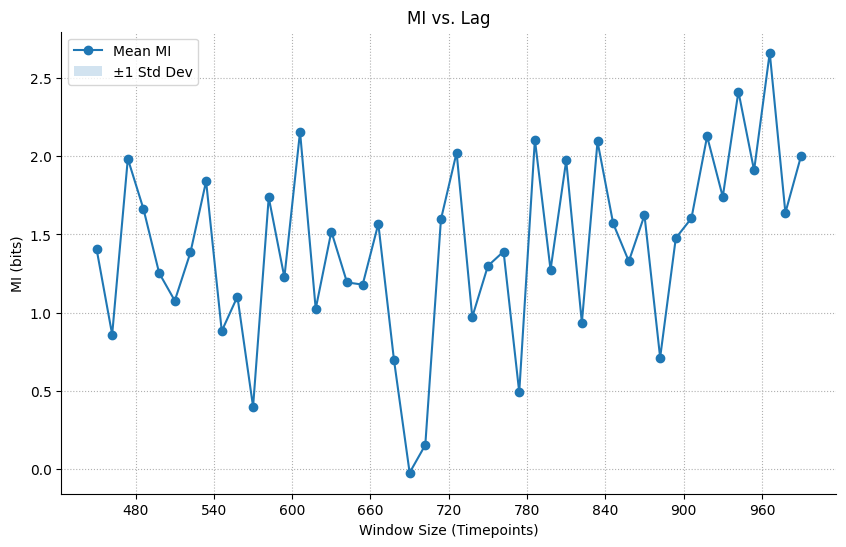

In [24]:
ax = raw_results.plot(show=False)
ax.set_xlabel('Window Size (Timepoints)')
ax.legend()
plt.show()

Doesn't make much sense, but that was expected. There are many directions for improvement (low-pass filter, loop over subjects and channels)

In [ ]:
lag_range = range(450, 750, 12)
window_range = list(range(5, 101, 5))
mi_results_2d = []

print("Starting 2D sweep...")
for lag in tqdm(lag_range, desc="Lag Sweep Progress"):
    results = nmi.run(
        x_data=x_scaled,
        y_data=y_scaled,
        mode='sweep',
        processor_type_x='continuous',
        processor_type_y='continuous',
        processor_params_x={},
        processor_params_y={},
        base_params=BASE_PARAMS,
        sweep_grid={'window_size': window_range},
        n_workers=8,
        verbose=False
    )

    for _, row in results.dataframe.iterrows():
        mi_results_2d.append({
            'lag': lag, 
            'window_size': row['window_size'],
            'mi': row['mi_mean']
        })

print("2D sweep complete!")
results_df_2d = pd.DataFrame(mi_results_2d)

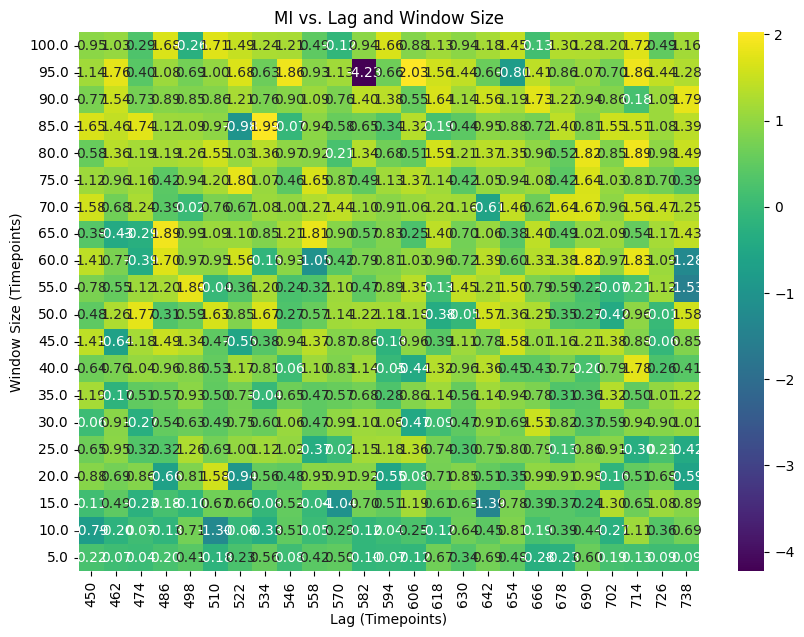

In [10]:
# Pivot the data for the heatmap
heatmap_data = results_df_2d.pivot(index='window_size', columns='lag', values='mi')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data, annot=True, cmap='viridis', fmt=".2f")
plt.title('MI vs. Lag and Window Size')
plt.xlabel('Lag (Timepoints)')
plt.ylabel('Window Size (Timepoints)')
plt.gca().invert_yaxis()
plt.show()

What's going on at 582 ms of lag, 95 timepoint window? 

In [ ]:
# Snippet for testing random channel pairs
# ---------------- CONFIGURATION ---------------- #
DATA_PATH = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
FILE_NAME = "binepochs filtered ICArej P1AvgBOS2.set"
OUTPUT_DIR = Path("../results/mi_lag_analysis_P1/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

N_PAIRS = 10  # number of random channel pairs to analyze
LAG_RANGE = range(400, 800, 10)  # in timepoints (depends on your sampling rate)

# NeuralMI base parameters
BASE_PARAMS = {
    'embedding_dim': 16,
    'hidden_dim': 32,
    'n_layers': 2,
    'learning_rate': 1e-3,
    'batch_size': 128,
    'n_epochs': 30,
    'patience': 15,
}

# ------------------------------------------------ #

# === 1. Load and preprocess data ===
file_path = DATA_PATH / FILE_NAME
epochs = mne.io.read_epochs_eeglab(file_path)

# Split auditory/tactile conditions (optional)
auditory_epochs = epochs[::2]
tactile_epochs = epochs[1::2]
sfreq = auditory_epochs.info['sfreq']

# Apply band-pass filter (in-place)
auditory_epochs.filter(*BANDPASS_RANGE, fir_design='firwin', verbose=False)

# Extract data array
X = auditory_epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
ch_names = auditory_epochs.ch_names

print(f"Data shape: {X.shape}, Sampling rate: {sfreq} Hz")

# === 2. Choose random pairs ===
pairs = [('T7', 'C3')]
# while len(pairs) < N_PAIRS:
#     a, b = random.sample(ch_names, 2)
#     if (a, b) not in pairs and (b, a) not in pairs:
#         pairs.append((a, b))

print("Channel pairs:", pairs)

Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.


C:\Users\Rinta\AppData\Local\Temp\ipykernel_11208\3378394966.py:26: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(file_path)


Data shape: (60, 32, 1792), Sampling rate: 512.0 Hz
Channel pairs: [('T7', 'C3')]


Extracting parameters from c:\Users\Rinta\Documents\Classes\PSYC 4745\Research Project\CISI Repo\Phys-Cog-CISI-Group\notebooks\..\data\raw\P1-20251027T182958Z-1-001\P1\binepochs filtered ICArej P1AvgBOS2.set...
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Ready.
Sampling freq: 512.0 Hz, n_epochs=120, n_channels=32
Applying baseline correction (mode: mean)


C:\Users\Rinta\AppData\Local\Temp\ipykernel_12008\2614043704.py:20: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = mne.io.read_epochs_eeglab(SET_FILE)


Applying baseline correction (mode: mean)
x_scaled: (1, 107520) y_scaled: (1, 107520)
Correlation between C3 and T7: 0.320


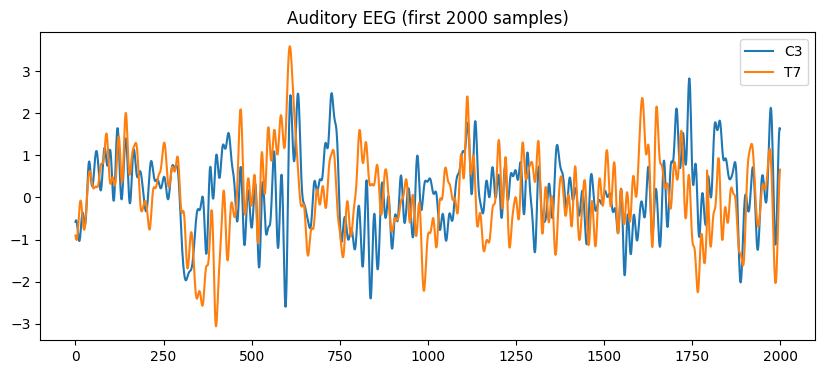

Running NeuralMI on original data...
2025-11-04 09:58:21 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 09:58:21 - neural_mi - INFO - Preparing 31 tasks for lag analysis.
2025-11-04 09:58:21 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-300_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-280_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-260_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-240_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-220_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-200_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-180_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-160_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-140_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-120_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-100_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-80_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-60_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-40_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-20_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag20_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag40_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag60_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag80_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag100_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag120_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag140_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag160_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag180_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag200_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag220_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag240_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag260_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag280_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag300_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Running NeuralMI on shuffled control...
2025-11-04 09:58:40 - neural_mi - INFO - Detected sweep over processor or lag parameters. Deferring data processing to workers.
2025-11-04 09:58:40 - neural_mi - INFO - Preparing 31 tasks for lag analysis.
2025-11-04 09:58:40 - neural_mi - INFO - Starting parameter sweep sequentially (n_workers=1)...


Sequential Sweep Progress:   0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\Rinta\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Run lag-300_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-280_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-260_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-240_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-220_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-200_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-180_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-160_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-140_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-120_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-100_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-80_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-60_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-40_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag-20_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag0_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag20_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag40_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag60_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag80_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag100_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag120_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag140_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag160_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag180_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag200_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag220_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag240_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag260_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag280_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

Run lag300_combo0:   0%|          | 0/50 [00:00<?, ?it/s]

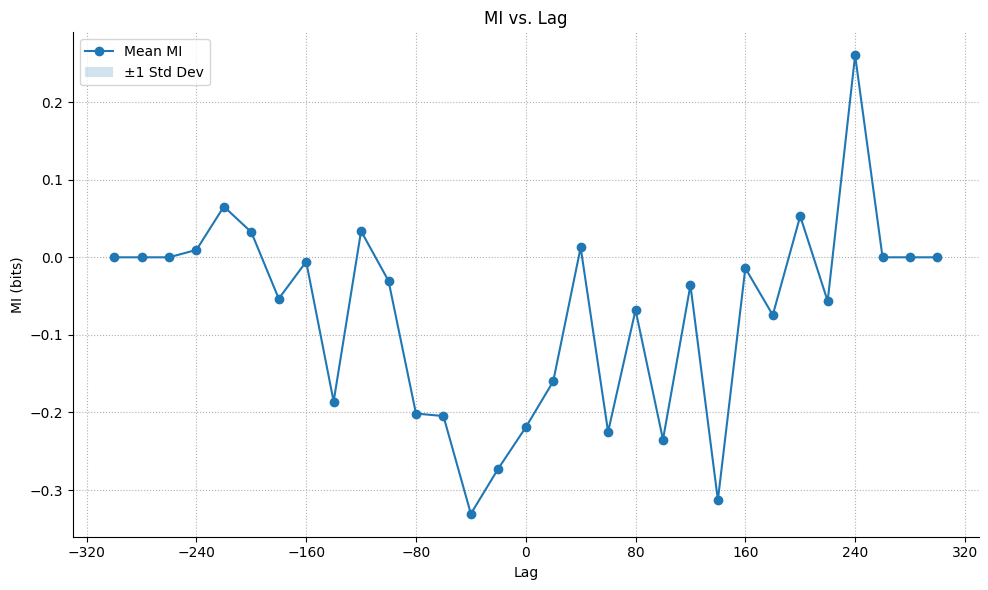

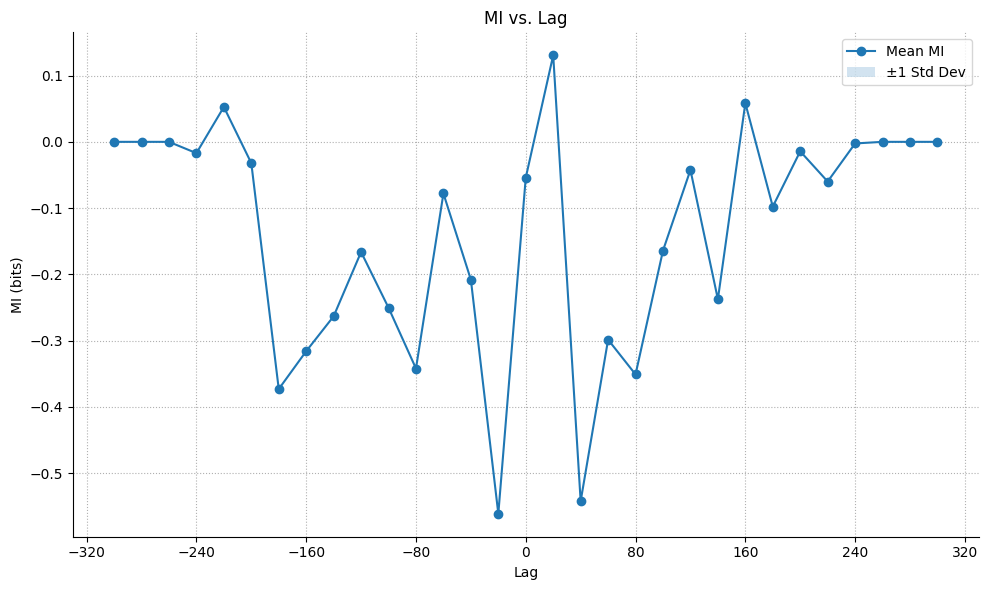

<Axes: title={'center': 'MI vs. Lag'}, xlabel='Lag', ylabel='MI (bits)'>

In [10]:
import numpy as np
import mne
from pathlib import Path
import matplotlib.pyplot as plt
import neural_mi as nmi
from sklearn.preprocessing import StandardScaler

# ---------------- CONFIG ---------------- #
DATA_PATH = Path("../data/raw/P1-20251027T182958Z-1-001/P1/")
SET_FILE = DATA_PATH / "binepochs filtered ICArej P1AvgBOS2.set"
CHANNELS = ('C3', 'T7')        # channel pair
BANDPASS = (1.0, 30.0)         # keep 1–30 Hz
BASELINE = (None, 0.0)
WINDOW_SEC = 0.5               # window length for MI (s)
LAG_RANGE = range(-300, 301, 20)
N_WORKERS = 1
# --------------------------------------- #

# --- Load subject epochs ---
epochs = mne.io.read_epochs_eeglab(SET_FILE)
sfreq = epochs.info['sfreq']
print(f"Sampling freq: {sfreq:.1f} Hz, n_epochs={len(epochs)}, n_channels={len(epochs.ch_names)}")

# --- Split stimuli ---
auditory_epochs = epochs[::2]
tactile_epochs  = epochs[1::2]

# --- Preprocess (baseline + bandpass) ---
for subset in [auditory_epochs, tactile_epochs]:
    subset.apply_baseline(BASELINE)
    subset.filter(l_freq=BANDPASS[0], h_freq=BANDPASS[1], picks="eeg", verbose=False)

# --- Get channel data & concatenate epochs ---
ch_names = epochs.ch_names
ix_x = ch_names.index(CHANNELS[0])
ix_y = ch_names.index(CHANNELS[1])

X = auditory_epochs.get_data()  # shape (n_epochs, n_channels, n_times)
x_raw = X[:, ix_x, :].reshape(-1)  # flatten all epochs
y_raw = X[:, ix_y, :].reshape(-1)

# --- Standardize (z-score) ---
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_raw.reshape(-1, 1)).reshape(1, -1)
y_scaled = scaler.fit_transform(y_raw.reshape(-1, 1)).reshape(1, -1)
print("x_scaled:", x_scaled.shape, "y_scaled:", y_scaled.shape)

# --- Quick sanity check ---
corr = np.corrcoef(x_scaled.flatten(), y_scaled.flatten())[0, 1]
print(f"Correlation between {CHANNELS[0]} and {CHANNELS[1]}: {corr:.3f}")

plt.figure(figsize=(10, 4))
plt.plot(x_scaled[0, :2000], label=CHANNELS[0])
plt.plot(y_scaled[0, :2000], label=CHANNELS[1])
plt.legend()
plt.title("Auditory EEG (first 2000 samples)")
plt.show()

# --- Windowing ---
win = int(WINDOW_SEC * sfreq)
starts = np.arange(0, x_scaled.shape[1] - win + 1, win)
Xw = np.stack([x_scaled[0, s:s + win] for s in starts])
Yw = np.stack([y_scaled[0, s:s + win] for s in starts])

# Window-level z-score
Xw = (Xw - Xw.mean(axis=1, keepdims=True)) / (Xw.std(axis=1, keepdims=True) + 1e-12)
Yw = (Yw - Yw.mean(axis=1, keepdims=True)) / (Yw.std(axis=1, keepdims=True) + 1e-12)

# Shuffle control
rng = np.random.default_rng(42)
Yw_shuf = Yw[rng.permutation(len(Yw))]

# --- NeuralMI parameters ---
base_params = {
    'n_epochs': 50,
    'learning_rate': 5e-4,
    'batch_size': 64,
    'patience': 10,
    'embedding_dim': 8,
    'hidden_dim': 64,
    'n_layers': 2
}
sweep_grid = {'critic_type': ['separable']}

# --- Run NeuralMI ---
print("Running NeuralMI on original data...")
res = nmi.run(
    x_data=Xw, y_data=Yw,
    mode='lag',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    processor_type_y='continuous',
    processor_params_y={'window_size': 1},
    lag_range=LAG_RANGE,
    base_params=base_params,
    sweep_grid=sweep_grid,
    n_workers=N_WORKERS,
    random_seed=42
)

print("Running NeuralMI on shuffled control...")
res_shuf = nmi.run(
    x_data=Xw, y_data=Yw_shuf,
    mode='lag',
    processor_type_x='continuous',
    processor_params_x={'window_size': 1},
    processor_type_y='continuous',
    processor_params_y={'window_size': 1},
    lag_range=LAG_RANGE,
    base_params=base_params,
    sweep_grid=sweep_grid,
    n_workers=N_WORKERS,
    random_seed=42
)

# --- Visualization ---
# lags = res.details.get('lags', np.arange(len(res.details['mi_curve'])))
# plt.figure(figsize=(8, 4))
# plt.plot(lags, res.details['mi_curve'], label='Original')
# plt.plot(lags, res_shuf.details['mi_curve'], '--', label='Shuffled')
# plt.xlabel("Lag (samples)")
# plt.ylabel("Mutual Information (bits)")
# plt.title(f"MI vs Lag — {CHANNELS[0]}–{CHANNELS[1]} (Auditory)")
# plt.legend()
# plt.grid(True)
# plt.show()
res.plot(show=True)
res_shuf.plot(show=True)